## Setup

In [3]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [4]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:09:07.168 | INFO     |  Running on cuda:0


In [5]:
task = 'Bread'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:09:08.137 | INFO     |  Loading dataset(s): 
2024-08-16 16:09:08.138 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Bread/demos/metadata.json
2024-08-16 16:09:08.147 | INFO     |    Extracted gt object labels []
2024-08-16 16:09:08.147 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:09:08.148 | INFO     |    Done! Data contains 4 trajectories.


In [6]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [7]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [8]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    # kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:09:14.615 | INFO     |  Subsampling to length 709 using strategy mean-length.


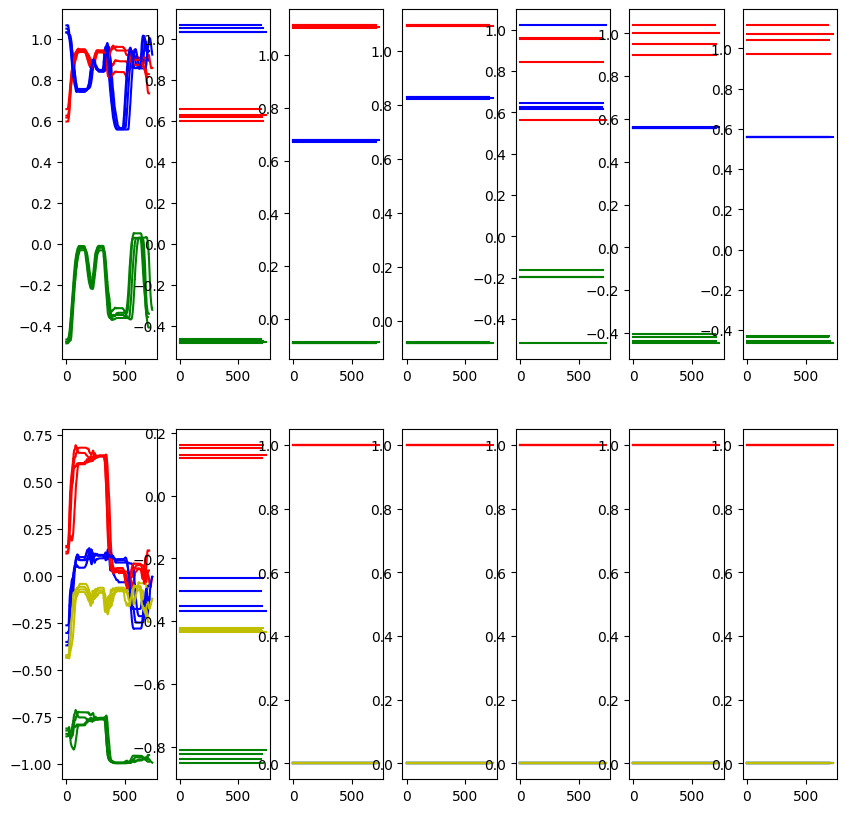

In [9]:
demos.debug_trajs()

In [10]:
tpgmm_config = TPGMMConfig(
    n_components=50,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    components_prop_to_len=True,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=5,

    velocity_threshold=0.0006,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [11]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:09:16.217 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:09:16.218 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:09:16.218 | INFO     |  Segmenting trajectories


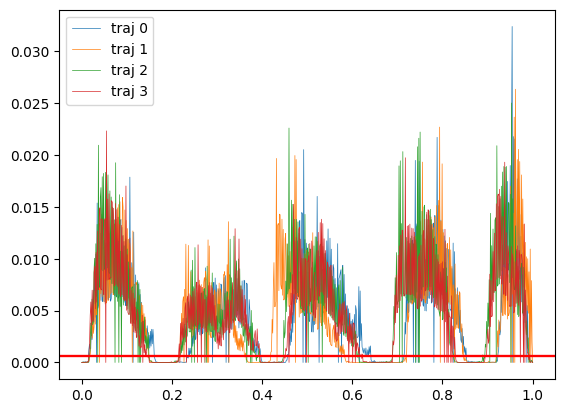

2024-08-16 16:09:16.391 | INFO     |  Creating segement of demos.
2024-08-16 16:09:16.392 | INFO     |  Subsampling to length 131 using strategy mean-length.
2024-08-16 16:09:16.393 | INFO     |  Creating segement of demos.
2024-08-16 16:09:16.394 | INFO     |  Subsampling to length 162 using strategy mean-length.
2024-08-16 16:09:16.394 | INFO     |  Creating segement of demos.
2024-08-16 16:09:16.396 | INFO     |  Subsampling to length 173 using strategy mean-length.
2024-08-16 16:09:16.396 | INFO     |  Creating segement of demos.
2024-08-16 16:09:16.397 | INFO     |  Subsampling to length 151 using strategy mean-length.
2024-08-16 16:09:16.398 | INFO     |  Creating segement of demos.
2024-08-16 16:09:16.399 | INFO     |  Subsampling to length 91 using strategy mean-length.
2024-08-16 16:09:16.399 | INFO     |  ... created 5 segments
2024-08-16 16:09:16.399 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:16.399 | INFO     |    Creating partial frame view of demos.
2024

Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:16.842 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:16.842 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:17.227 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:17.228 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:17.609 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:17.609 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:17.978 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:17.978 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:18.355 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:18.356 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:18.737 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:09:18.737 | INFO     |  kp 0       score (rel):     -0 (0.438)
2024-08-16 16:09:18.737 | INFO     |  kp 1       score (rel):     -1 (0.579)
2024-08-16 16:09:18.737 | INFO     |  kp 2       score (rel):     -0 (0.010)
2024-08-16 16:09:18.738 | INFO     |  kp 3       score (rel):     -0 (0.101)
2024-08-16 16:09:18.738 | INFO     |  kp 4       score (rel):     -0 (0.103)
2024-08-16 16:09:18.738 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:18.813 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:18.813 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:09:18.818 | INFO     |    Changing number of components to 11


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:19.201 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:19.201 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:19.633 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:19.633 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:20.122 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:20.122 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:20.628 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:20.628 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:21.093 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:21.094 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:21.718 | INFO     |  ee_init    score (rel):     -0 (0.028)
2024-08-16 16:09:21.719 | INFO     |  kp 0       score (rel):     -1 (1.000)
2024-08-16 16:09:21.719 | INFO     |  kp 1       score (rel):     -1 (0.923)
2024-08-16 16:09:21.719 | INFO     |  kp 2       score (rel):     -0 (0.001)
2024-08-16 16:09:21.719 | INFO     |  kp 3       score (rel):     -0 (0.061)
2024-08-16 16:09:21.719 | INFO     |  kp 4       score (rel):     -0 (0.066)
2024-08-16 16:09:21.719 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:21.768 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:21.768 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:09:21.775 | INFO     |    Changing number of components to 12


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:22.282 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:22.282 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:22.825 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:22.825 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:23.387 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:23.388 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:23.943 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:23.944 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:24.484 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:24.485 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:25.161 | INFO     |  ee_init    score (rel):     -0 (0.346)
2024-08-16 16:09:25.162 | INFO     |  kp 1       score (rel):     -0 (0.824)
2024-08-16 16:09:25.162 | INFO     |  kp 2       score (rel):     -0 (0.027)
2024-08-16 16:09:25.162 | INFO     |  kp 3       score (rel):     -1 (0.976)
2024-08-16 16:09:25.162 | INFO     |  kp 4       score (rel):     -0 (0.779)
2024-08-16 16:09:25.162 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:25.236 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:25.236 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:09:25.240 | INFO     |    Changing number of components to 10


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:25.566 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:25.567 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:25.977 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:25.978 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:26.453 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:26.454 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:26.880 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:26.880 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:27.281 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:27.282 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:27.683 | INFO     |  ee_init    score (rel):     -0 (0.193)
2024-08-16 16:09:27.683 | INFO     |  kp 0       score (rel):     -0 (0.767)
2024-08-16 16:09:27.683 | INFO     |  kp 1       score (rel):     -0 (0.720)
2024-08-16 16:09:27.683 | INFO     |  kp 2       score (rel):     -0 (0.005)
2024-08-16 16:09:27.683 | INFO     |  kp 3       score (rel):     -1 (1.000)
2024-08-16 16:09:27.683 | INFO     |  kp 4       score (rel):     -0 (0.775)
2024-08-16 16:09:27.684 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:27.760 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:27.760 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:09:27.763 | INFO     |    Changing number of components to 6


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:28.018 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:28.018 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:28.217 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:28.217 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:28.427 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:28.427 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:28.620 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:28.620 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:28.869 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:28.870 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:29.101 | INFO     |  ee_init    score (rel):     -0 (0.992)
2024-08-16 16:09:29.102 | INFO     |  kp 0       score (rel):     -0 (1.000)
2024-08-16 16:09:29.102 | INFO     |  kp 1       score (rel):     -0 (0.941)
2024-08-16 16:09:29.102 | INFO     |  kp 2       score (rel):     -0 (0.002)
2024-08-16 16:09:29.102 | INFO     |  kp 3       score (rel):     -0 (0.366)
2024-08-16 16:09:29.102 | INFO     |  kp 4       score (rel):     -0 (0.349)
2024-08-16 16:09:29.102 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:29.178 | INFO     |  Segmented trajs into 5 segments
2024-08-16 16:09:29.181 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.997551 -0.437113 -0.577447 -0.010060 -0.100805 -0.102295
Segment 1 -0.015414 -0.559102 -0.516180 -0.000570 -0.034315 -0.037164
Segment 2 -0.195390 -0.565062 -0.465858 -0.015011 -0.551299 -0.440313
Segment 3 -0.106299 -0.422065 -0.396223 -0.002580 -0.55

Fitting segments:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:09:29.189 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:30.521 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:33.858 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

((array([[1.82e+21, 2.10e+21, 2.36e+21, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [9.62e+16, 1.71e+17, 2.92e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.06e-09, 4.90e-09, 1.12e-08, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.47e+18, 1.27e+18, 1.07e+18]]),
  array([[4.46e+020, 5.18e+020, 5.88e+020, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.07e+018, 3.47e+018, 5.68e+018, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.55e+011, 1.16e+012, 3.67e+012, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.98e-231, 3.05e-229, 4.57e-227, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [9.93e-237, 1.19e-234, 1.40e-232, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [8.10e-241, 1.20e-238, 1.74e-236, ..., 7.43e+

In [12]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:09:34.682 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:09:34.682 | INFO     |  Segmenting trajectories


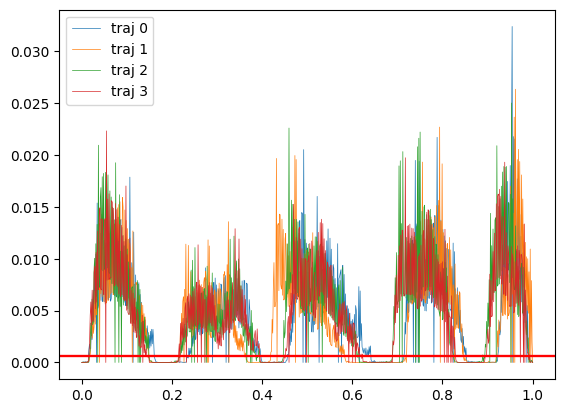

2024-08-16 16:09:34.838 | INFO     |  Creating segement of demos.
2024-08-16 16:09:34.841 | INFO     |  Creating segement of demos.
2024-08-16 16:09:34.844 | INFO     |  Creating segement of demos.
2024-08-16 16:09:34.847 | INFO     |  Creating segement of demos.
2024-08-16 16:09:34.849 | INFO     |  Creating segement of demos.
2024-08-16 16:09:34.851 | INFO     |  ... created 5 segments
2024-08-16 16:09:34.852 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:34.852 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:35.135 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:35.135 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:35.577 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:35.577 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:35.927 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:35.927 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:36.443 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:36.444 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:37.017 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:37.017 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:09:37.583 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:37.664 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:37.664 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:38.178 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:38.179 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:38.755 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:38.755 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:39.300 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:39.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:39.993 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:39.994 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:40.924 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:40.924 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:09:41.658 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:41.733 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:41.733 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:42.310 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:42.310 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:43.230 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:43.231 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:44.148 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:44.149 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:45.055 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:45.056 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:45.796 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:45.797 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:09:46.584 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:46.703 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:46.703 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:47.093 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:47.093 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:47.539 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:47.540 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:48.010 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:48.011 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:48.433 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:48.433 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:48.895 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:48.896 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:49.418 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:49.420 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:49.420 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:49.620 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:49.621 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:49.859 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:49.860 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:50.068 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:50.068 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:50.256 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:50.256 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:50.447 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:50.447 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:09:50.641 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:50.717 | INFO     |  Segmented trajs into 5 segments
2024-08-16 16:09:50.719 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.997551 -0.437113 -0.577447 -0.010060 -0.100805 -0.102295
Segment 1 -0.015414 -0.559102 -0.516180 -0.000570 -0.034315 -0.037164
Segment 2 -0.195390 -0.565062 -0.465858 -0.015011 -0.551299 -0.440313
Segment 3 -0.106299 -0.422065 -0.396223 -0.002580 -0.550467 -0.426666
Segment 4 -0.473349 -0.477339 -0.449218 -0.001121 -0.174615 -0.166421
2024-08-16 16:09:50.721 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0  1.000000  0.438186  0.578865  0.010085  0.101052  0.102546
Segment 1  0.027570  1.000000  0.923230  0.001020  0.061376  0.066471
Segment 2  0.345786  1.000000  0.824436  0.026565  0.975642  0.779230
Segment 3  0.193106  0.766740  0.719794 

Fitting segments:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

((array([[1.82e+21, 2.10e+21, 2.36e+21, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [9.62e+16, 1.71e+17, 2.92e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.06e-09, 4.90e-09, 1.12e-08, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.47e+18, 1.27e+18, 1.07e+18]]),
  array([[4.46e+020, 5.18e+020, 5.88e+020, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.07e+018, 3.47e+018, 5.68e+018, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.55e+011, 1.16e+012, 3.67e+012, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.98e-231, 3.05e-229, 4.57e-227, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [9.93e-237, 1.19e-234, 1.40e-232, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [8.10e-241, 1.20e-238, 1.74e-236, ..., 7.43e+

In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


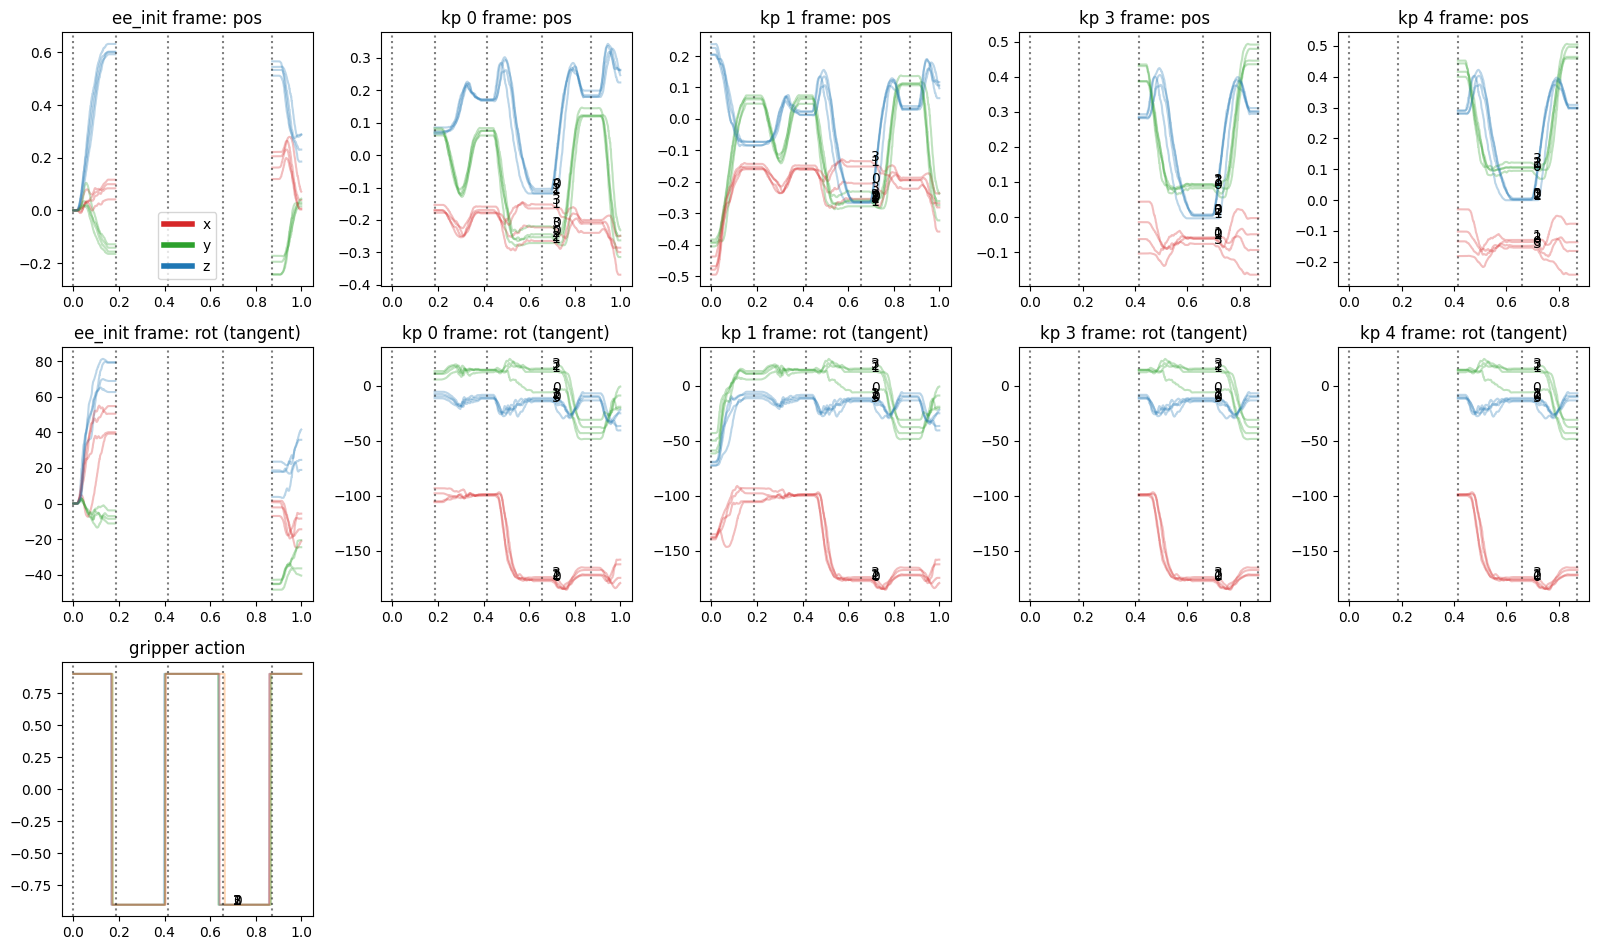

In [14]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [15]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:09:57.526 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:09:57.527 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:09:57.532 | INFO     |  HMM EM ...
2024-08-16 16:09:57.536 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:09:57.645 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:09:59.421 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [5.29e-05, 8.16e-05, 1.24e-04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.14e-30, 2.34e-30, 4.76e-30, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[9.95e-001, 9.93e-001, 9.90e-001, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.63e-003, 6.66e-003, 9.56e-003, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [7.92e-010, 2.23e-009, 6.18e-009, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [4.43e-252, 5.85e-250, 7.70e-248, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.22e-257, 2.28e-255, 2.36e-253, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.81e-261, 2.30e-259, 2.93e-257, ..., 1.00e+

2024-08-16 16:10:31.746 | INFO     |  Did not specify time_based, deciding automatically.


2024-08-16 16:10:32.515 | WARNING  |  Skippig NaN Gaussians.


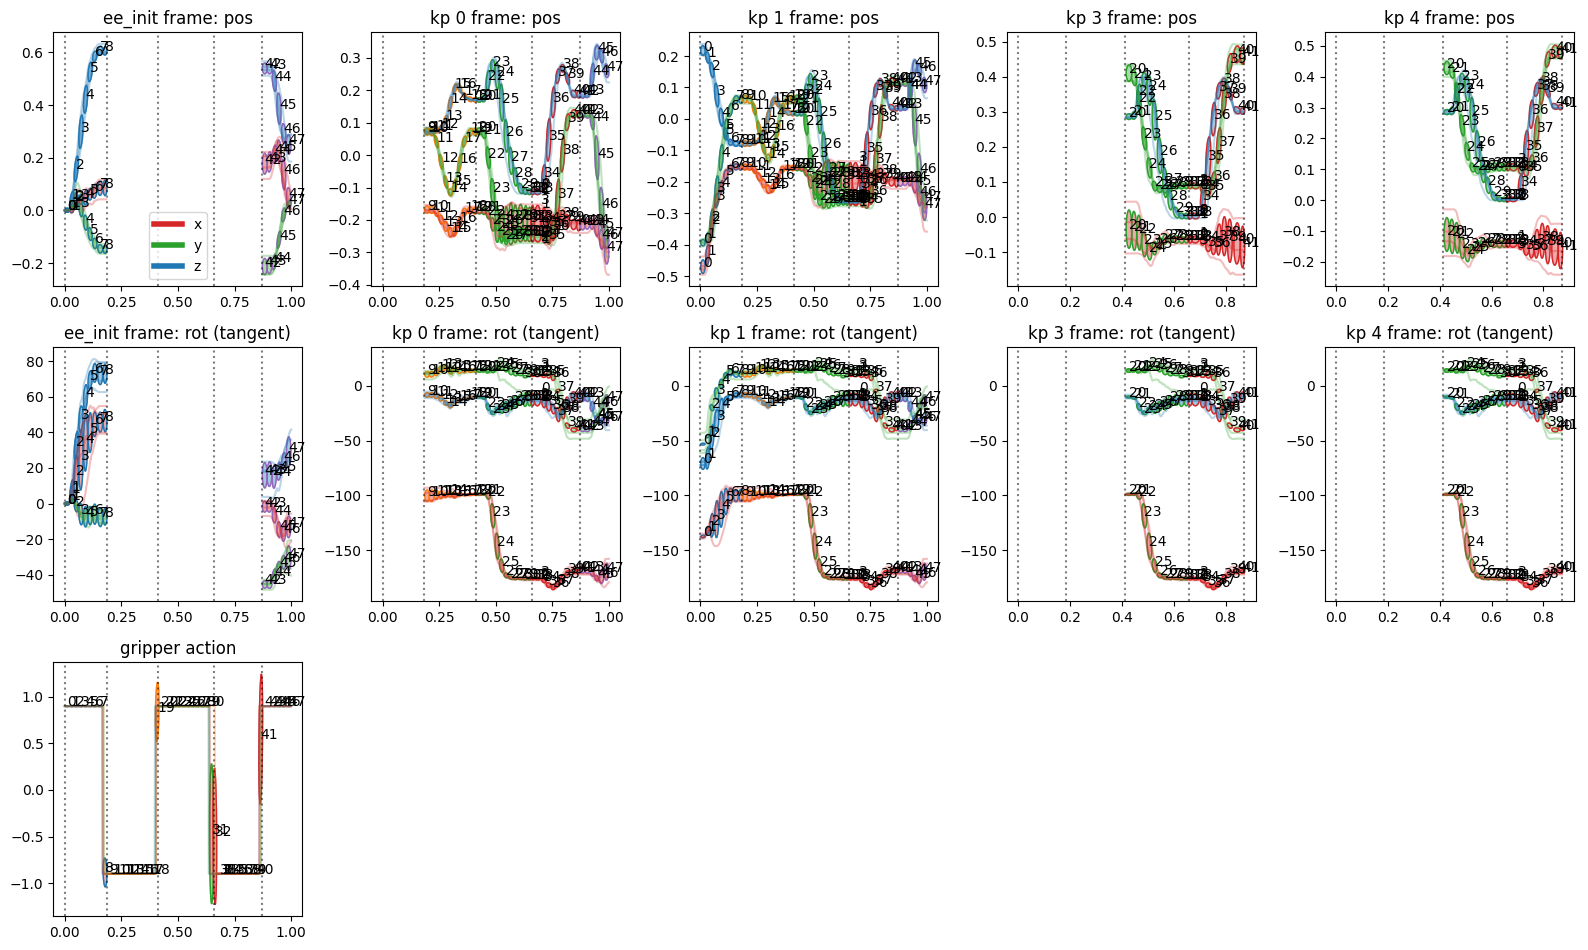

In [16]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [17]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:10:43.638 | INFO     |  Saving model:


2024-08-16 16:10:43.855 | INFO     |  Did not specify time_based, deciding automatically.


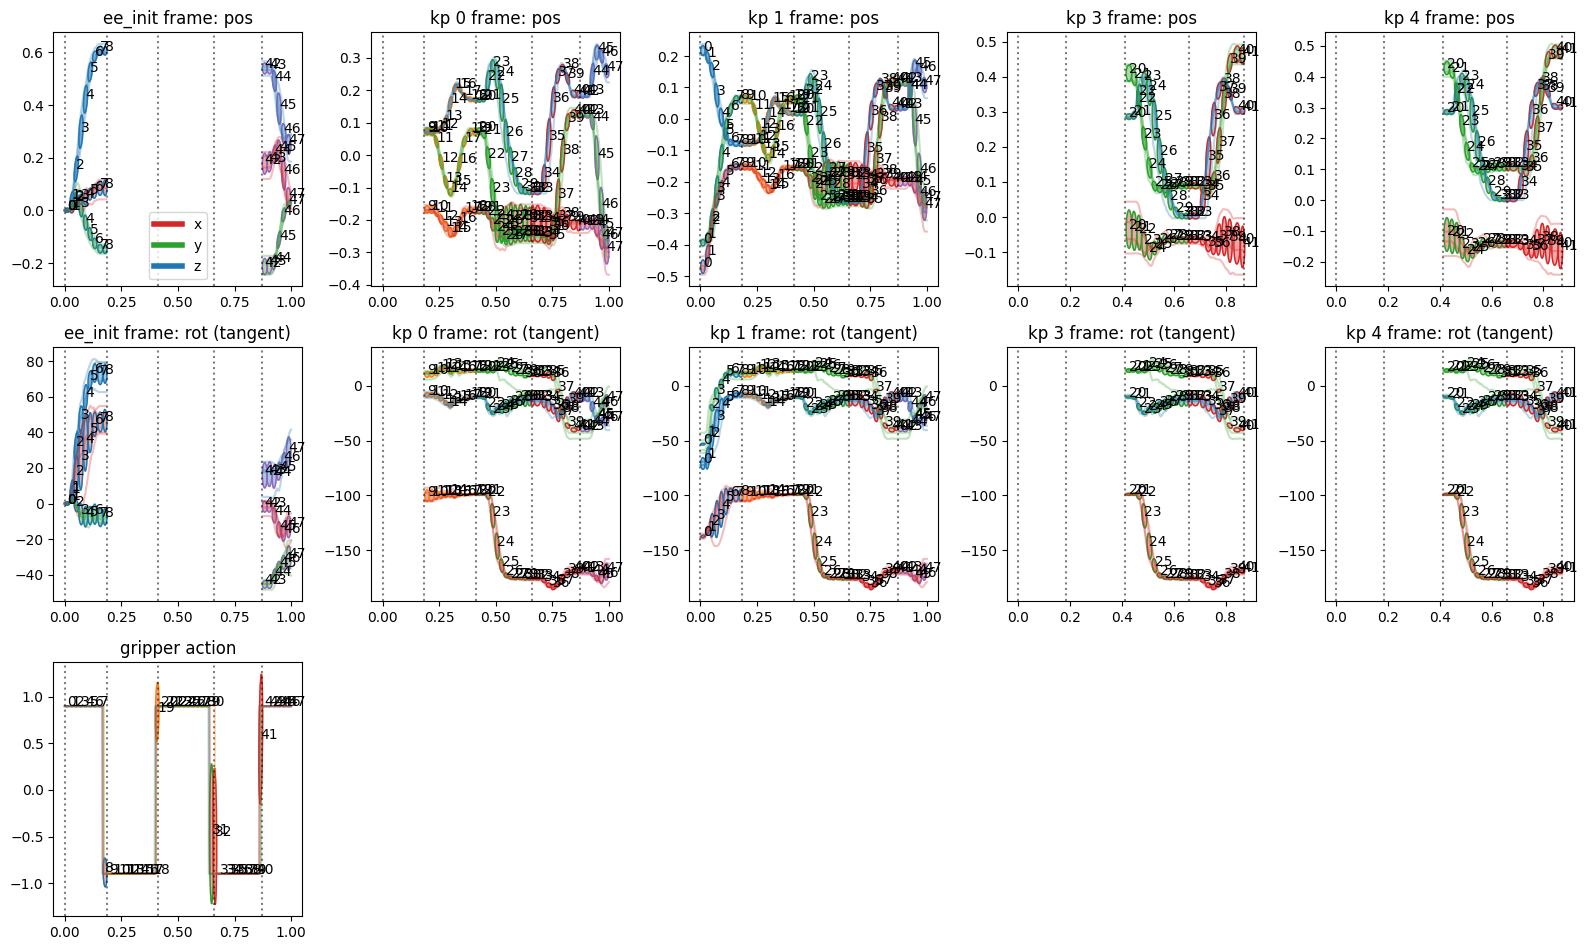

In [18]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


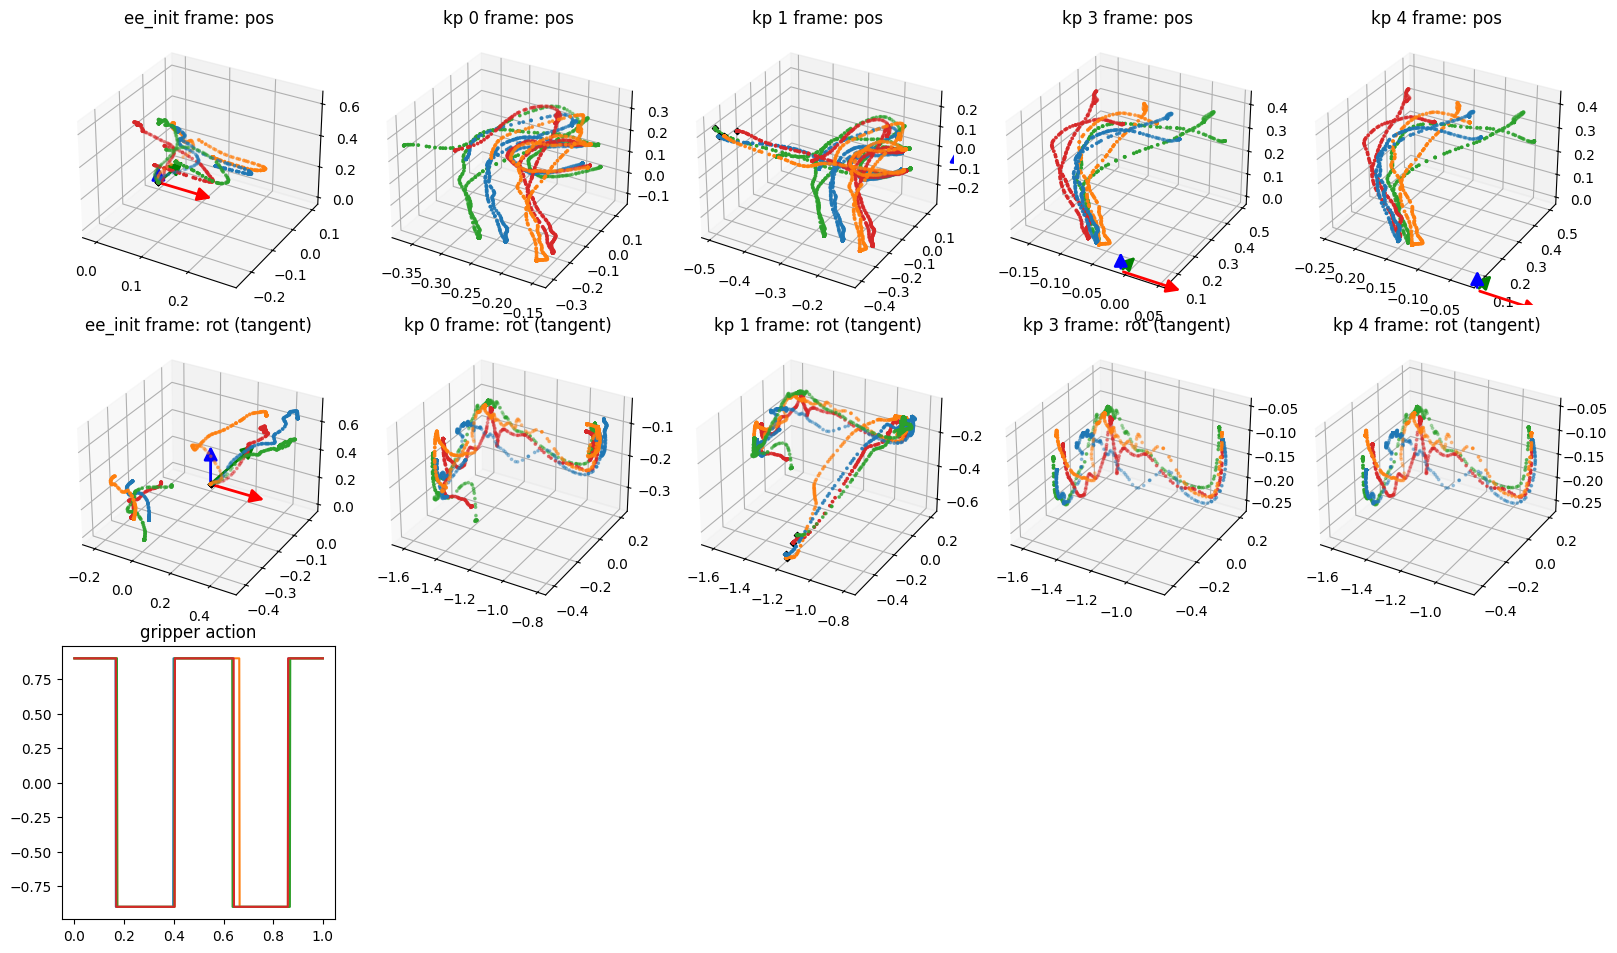

In [19]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [20]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:10:58.412 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:10:58.594 | INFO     |  Caculated segment transition probabilities: (array([[0.99]]), array([[0.99]]), array([[0.99]]), array([[0.98]]))
2024-08-16 16:10:58.594 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:58.596 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:59.011 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:59.717 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:00.644 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:01.719 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:02.242 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

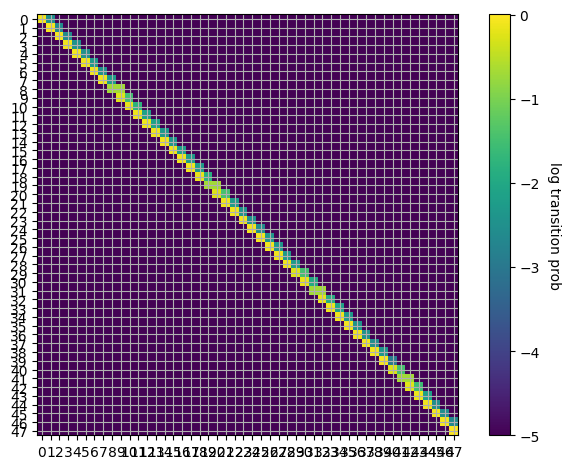

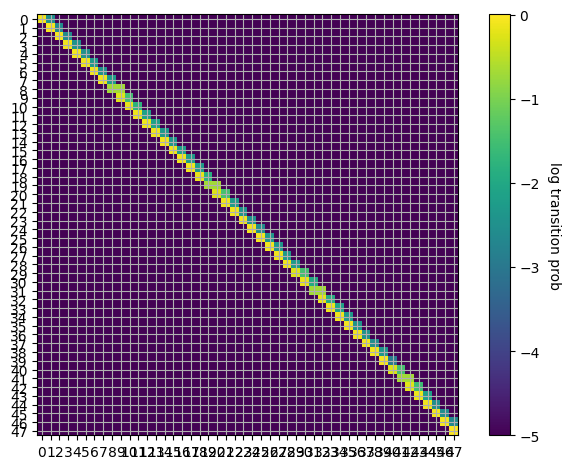

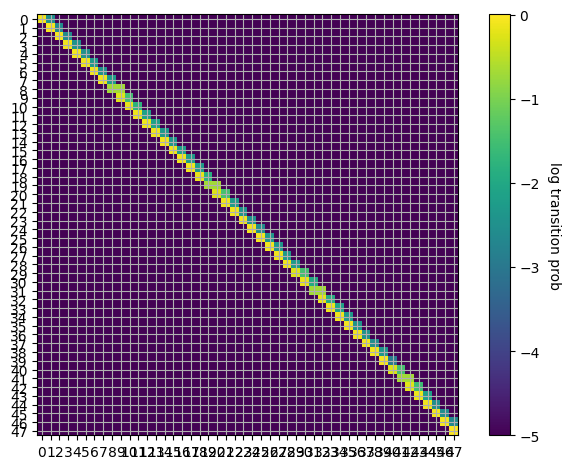

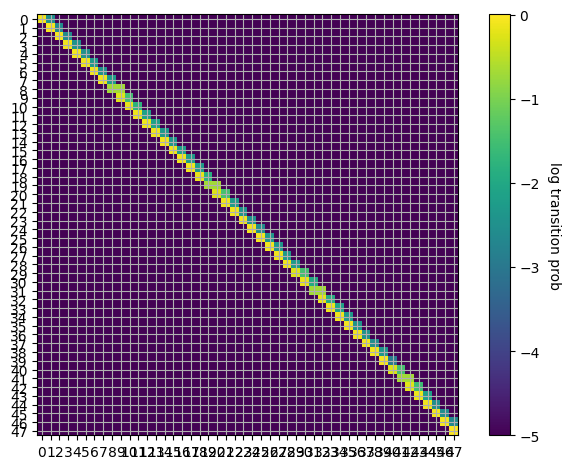

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-06-19 13:27:38.291 | INFO     |  Taking frame origins from demos.


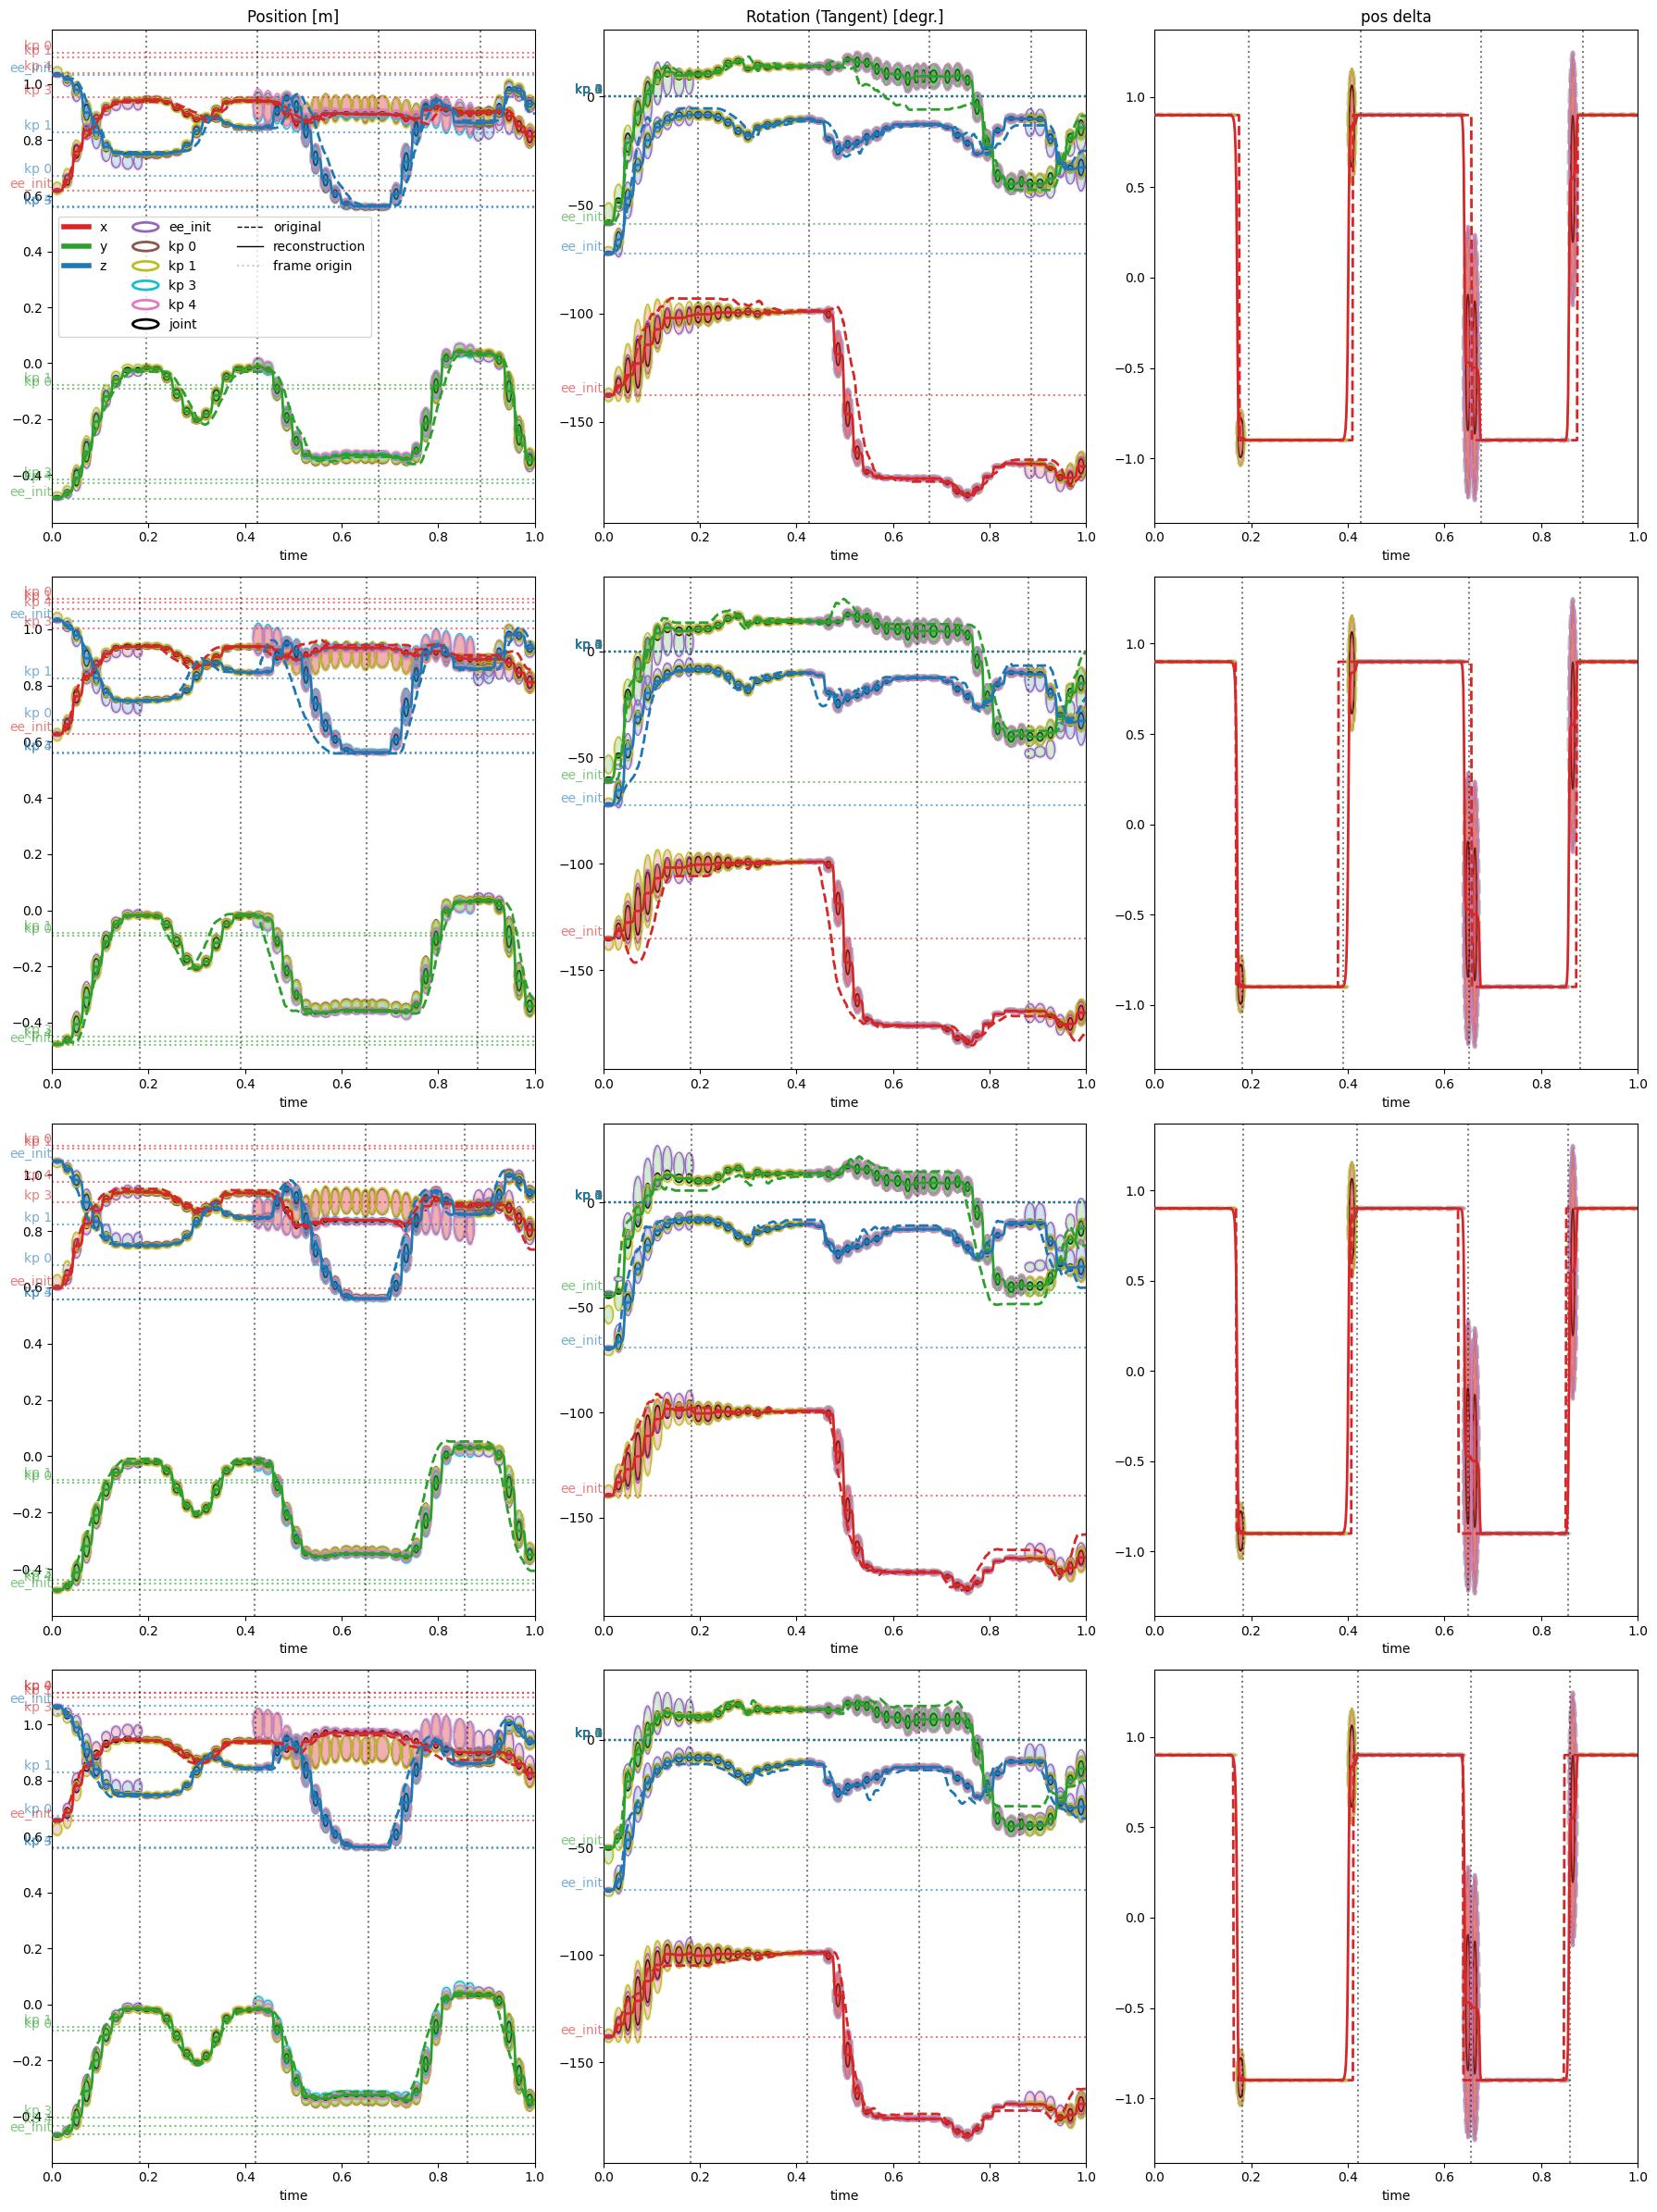

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


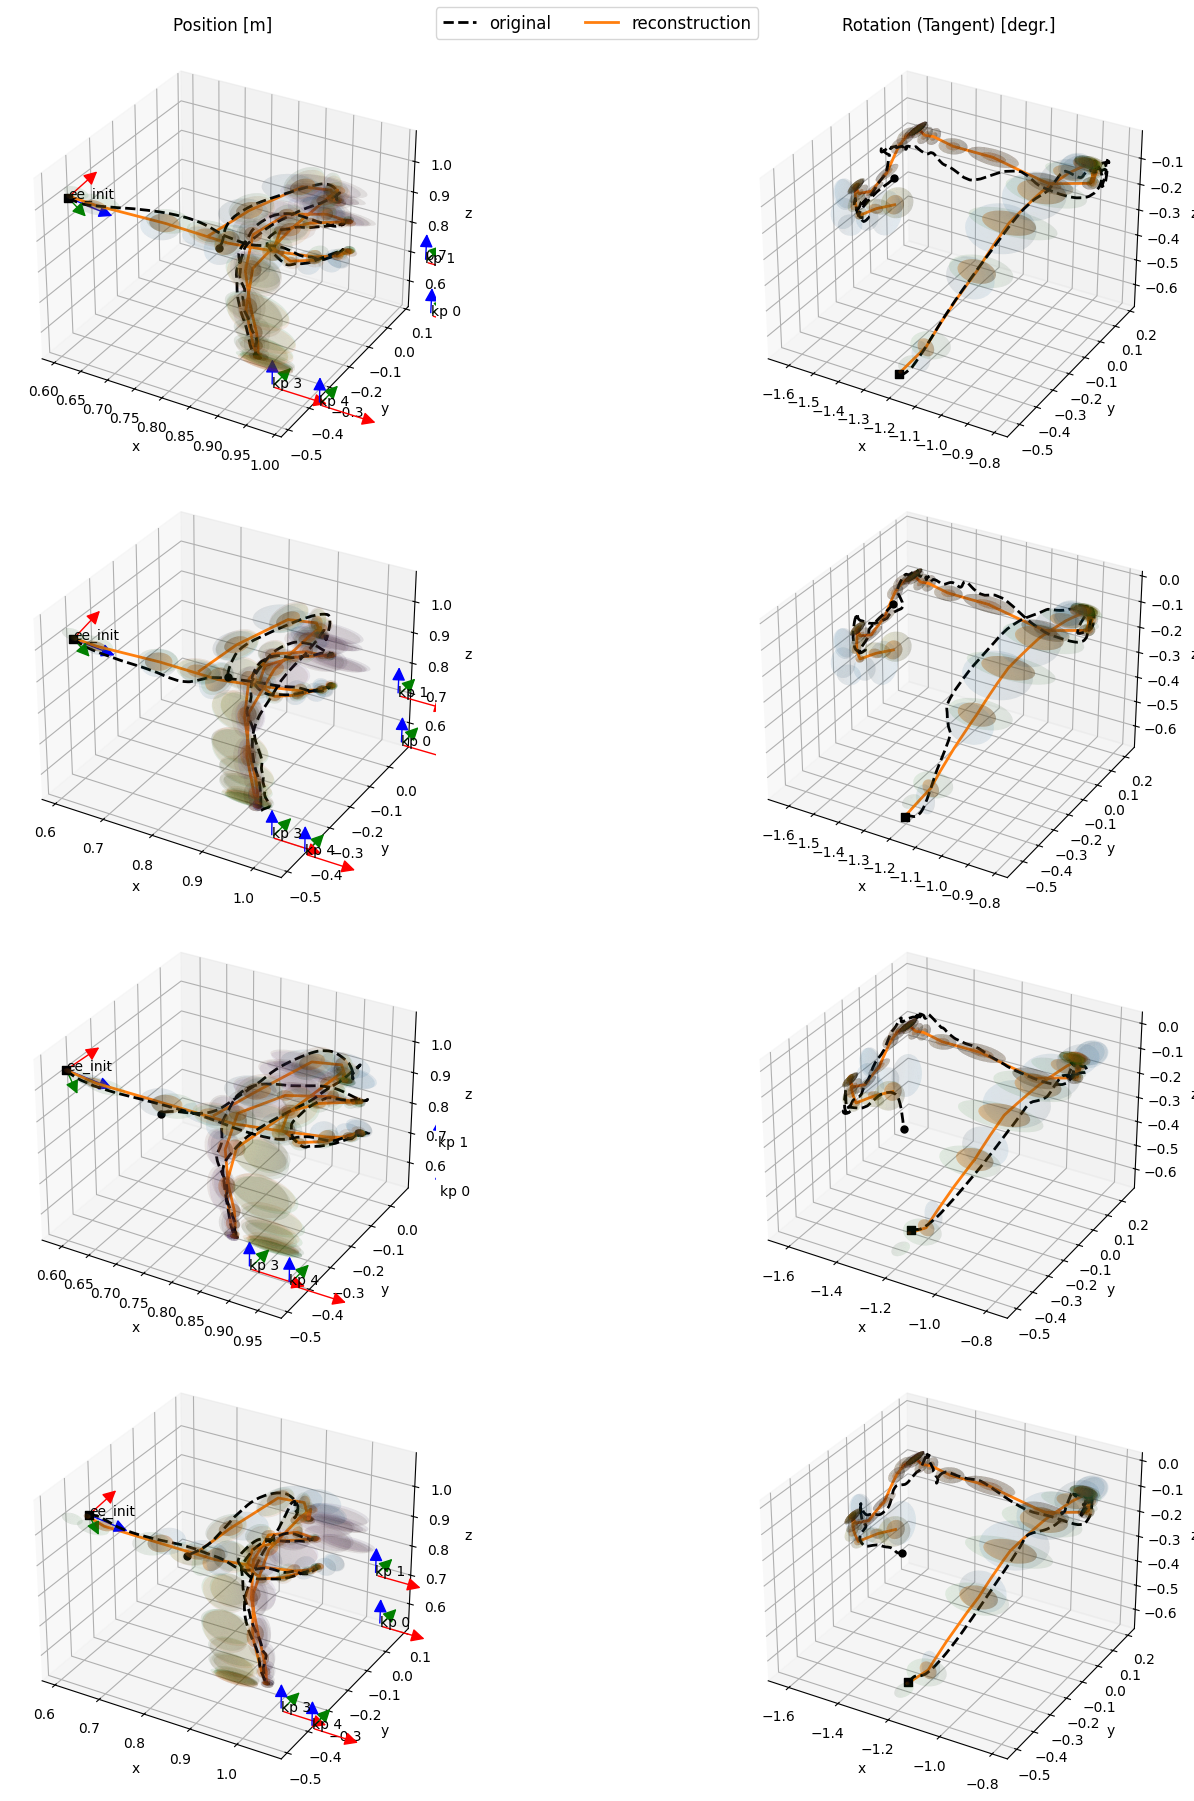

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)